
Python was not able to load the fast fortran material routines.


*************************************************************
Loading gmsh-mesh from H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/2_partitions_2quad_mesh.msh
Mesh H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/2_partitions_2quad_mesh.msh successfully imported. 
Assign a material to a physical group.
*************************************************************


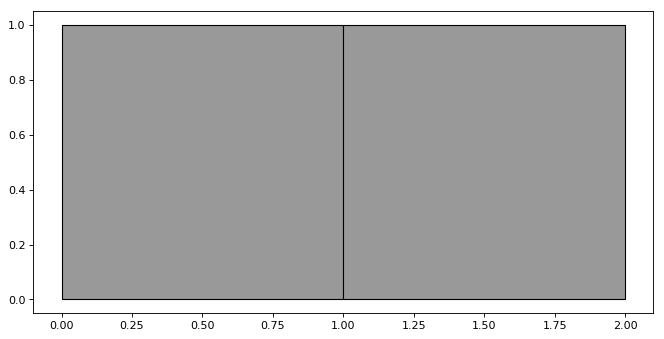

In [1]:
# importing lib and setting a list of meshes to be tested
import sys 
import amfe
import matplotlib.pyplot as plt
import numpy as np
import scipy
import copy
import pandas as pd

msh_dict = {}
msh_dict[0] = amfe.amfe_dir('meshes/test_meshes/Geom3.msh')
msh_dict[1] = amfe.amfe_dir('meshes/test_meshes/simple_2.msh')
msh_dict[2] = mshfile = amfe.amfe_dir('meshes/test_meshes/3_partition_pressure_corner.msh')
msh_dict[3] = mshfile = amfe.amfe_dir('meshes/test_meshes/geo_hole_quad_part_4.msh')
msh_dict[4] = mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_quad_mesh.msh')
msh_dict[5] = mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_2quad_mesh.msh')
msh_dict[6] = mshfile = amfe.amfe_dir('meshes/test_meshes/4_partitions_quad_mesh.msh')
msh_dict[7] = mshfile = amfe.amfe_dir('meshes/test_meshes/3_partition_2d_blade_quad_mesh.msh')
msh_dict[8] = mshfile = amfe.amfe_dir('meshes/test_meshes/1_quad_elem.msh')


domain_id = {}
domain_id[0] = 3
domain_id[1] = 3
domain_id[2] = 11
domain_id[3] = 8
domain_id[4] = 3
domain_id[5] = 3
domain_id[6] = 3
domain_id[7] = 3
domain_id[8] = 6


# select mesh to be plotted
mesh_id1 = 5
mshfile = msh_dict[mesh_id1]

m1 = amfe.Mesh()
m1.import_msh(mshfile)

domain = m1.set_domain('phys_group', domain_id[mesh_id1])

fig, ax1=plt.subplots(1,figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
amfe.plot_submesh(domain,ax1)
plt.show()


*************************************************************
Loading gmsh-mesh from H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/1_quad_elem.msh
Mesh H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/1_quad_elem.msh successfully imported. 
Assign a material to a physical group.
*************************************************************


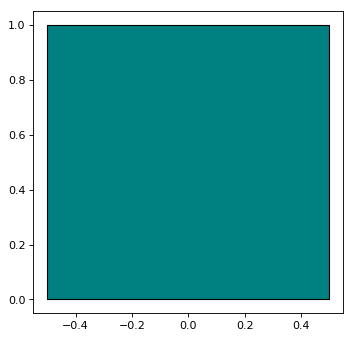

In [2]:
# select mesh to be plotted
mesh_id2 = 8
mshfile = msh_dict[mesh_id2]

m2 = amfe.Mesh()
m2.import_msh(mshfile)

domain = m2.set_domain('phys_group', domain_id[mesh_id2])
submesh3 = domain

fig, ax1=plt.subplots(1,figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
amfe.plot_submesh(domain,ax1)
plt.show()

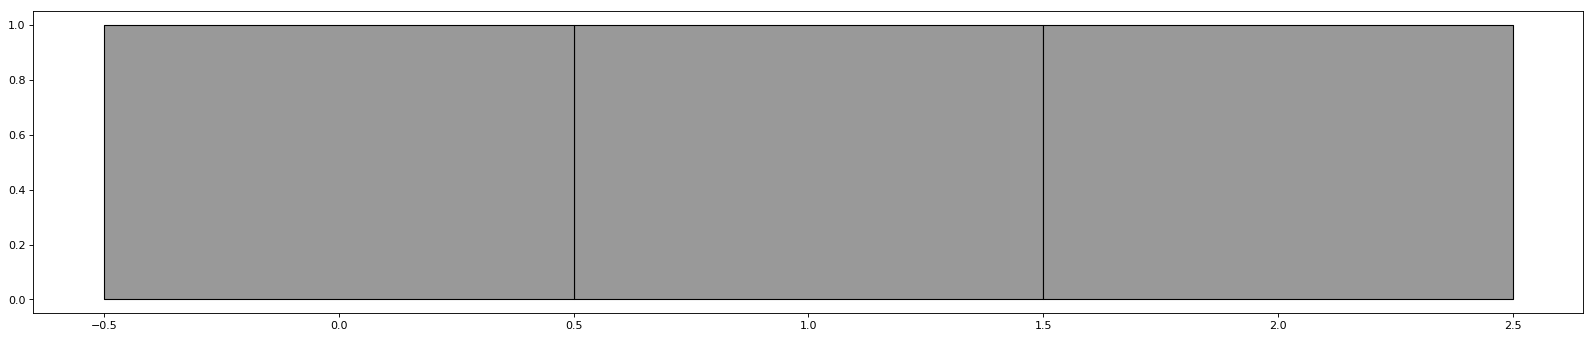

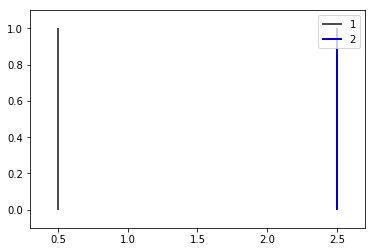

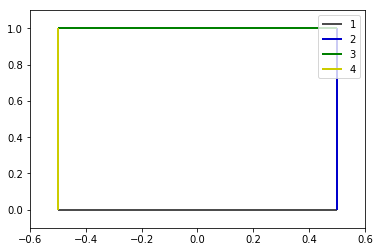

In [3]:
# applying tranlation to mesh

sys.path.append(r"H:\TUM-PC\Dokumente\Projects\FETI")
from cyclic_domain_test import *

key  = 1
x_offset = 0.5
y_offset = 0.0
z_offset = 0.0
vector_offset = [x_offset,y_offset,z_offset]
new = translation(m1.nodes,vector_offset)


# creating submesh 1
submesh1 = copy.deepcopy(m1.groups[domain_id[mesh_id1]])
submesh1.parent_mesh.nodes = new
submesh1 = m1.groups[domain_id[mesh_id1]]
submesh1.parent_mesh.nodes = new

# creating submesh 2
submesh2 = copy.deepcopy(submesh1)
new = rot_z(submesh2.parent_mesh.nodes,180,ref_point_vector=[0,0.5,0])
submesh2.parent_mesh.nodes = new

fig, ax1=plt.subplots(1,figsize=(25, 5), dpi= 80, facecolor='w', edgecolor='k')
amfe.plot_submesh(submesh1,ax1)
amfe.plot_submesh(submesh3,ax1)



amfe.plot_boundary_1d(submesh1.parent_mesh)
amfe.plot_boundary_1d(submesh3.parent_mesh)
plt.show()


In [4]:
# creating material
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=0.1)

# append domains to MechanicalAssembly
my_system = amfe.MechanicalAssembly()
my_system.append_domain(submesh1, my_material, 1)
my_system.append_domain(submesh3, my_material, 3)
my_system.update_global_system()


In [5]:
# select submesh for interfaces to be connected
sub_int1 = my_system.get_submesh(1,1)
sub_int2 = my_system.get_submesh(3,2)

# apply connection between surfaces
my_system.add_bound_interface_constraint(sub_int1,sub_int2)

# replacing phys tags to avoid conflict
my_system.change_domain_physical_tag(1,3,6)
my_system.change_domain_physical_tag(1,2,8)

AttributeError: 'MechanicalAssembly' object has no attribute 'add_bound_interface_constraint'

In [ ]:
new_mesh = my_system.mesh_class
new_mesh.connectivity = []
new_mesh.ele_obj = []

fig, ax1=plt.subplots(1,figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
amfe.plot_mesh(new_mesh,ax1)
plt.show()

In [ ]:
# setting domain and B.C.
value = 1e8
my_system = amfe.MechanicalSystem()
my_system.set_mesh_obj(new_mesh)
my_system.set_domain(6,my_material)
my_system.apply_dirichlet_boundaries(4, 'xy')
my_system.apply_neumann_boundaries(8, value, 'normal')


In [ ]:
s = amfe.LinearStaticsSolver(my_system)
s.solve()

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_static(scale=1):
    amfe.plot_system_solution(my_system, factor=scale)
    plt.show()
    
interact(plot_static,scale=(0,1000,5))  